# Project: Avatar: Fire and Ash Box Office Prediction

## Objective
The primary goal of this project is to predict the global box office revenue for the upcoming movie **"Avatar: Fire and Ash"** (Release Date: Dec 19, 2025).

To achieve this, we will:
1. **Scrape Data:** Build a dataset of 5,000+ movies using the TMDB API (metadata) and YouTube (trailer views).
2. **Fact Table Creation:** Construct a comprehensive dataset including features like budget, genres, cast, director, and digital footprint (trailer views).
3. **Modeling:** Train regression models (Random Forest, XGBoost, etc.) ensuring strictly temporal train/test splits to preventing data leakage.
4. **Inference:** Predict the final box office for the target movie.

In [1]:
# Install necessary libraries for scraping
!pip install tmdbv3api yt-dlp pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import ast

# Scraper Imports
from tmdbv3api import TMDb, Movie, Discover
from yt_dlp import YoutubeDL

# Formatting for outputs
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries installed and imported successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 101.2 MB/s eta 0:00:00
Libraries installed and imported successfully.


In [2]:
# --- CONFIGURATION ---
tmdb = TMDb()
tmdb.api_key = '5cd2e12bc99c9ee5c18117404fa41404'
tmdb.language = 'en'
tmdb.debug = True

movie_api = Movie()
discover_api = Discover()

print("TMDB API Configured.")

TMDB API Configured.


## Load Data (Web Scraping)
In this step, we collect our raw data.
1. **TMDB:** We use the `Discover` API to find movies, prioritizing **Sci-Fi, Action, and Adventure** genres sorted by revenue.
2. **YouTube:** For each movie, we use `yt-dlp` to search for the "Official Trailer" and extract the view count.
3. **Data Storage:** We store the results in a DataFrame and save it as `raw_movie_data.csv`.

In [5]:
import pandas as pd
import time
import re
from tmdbv3api import TMDb, Movie, Discover
from yt_dlp import YoutubeDL

# Ensure API is configured
tmdb = TMDb()
tmdb.language = 'en'
movie_api = Movie()
discover_api = Discover()

# 1. YouTube Function (From your uploaded notebook)
def get_trailer_stats_ytdlp(movie_title):
    ydl_opts = {
        'default_search': 'ytsearch1:', # Search YouTube and take the 1st result
        'quiet': True,                  # Don't print a wall of text
        'skip_download': True,          # We only want data
        'no_warnings': True,
    }

    with YoutubeDL(ydl_opts) as ydl:
        try:
            # Clean title for better search results
            clean_title = re.sub(r'[^\w\s]', '', movie_title)
            query = f"{clean_title} Official Trailer"

            # Extract info
            info = ydl.extract_info(query, download=False)

            # 'ytsearch1' returns a list called 'entries', we take the first one
            if 'entries' in info:
                video = info['entries'][0]
            else:
                video = info

            return {
                'Trailer_Views': video.get('view_count', 0),
                'Trailer_Title': video.get('title', 'N/A')
            }
        except Exception as e:
            # print(f"Error for {movie_title}: {e}") # Uncomment to debug
            return None

# 2. Main Scraping Loop
target_count = 5000
movies_data = []
seen_ids = set()

# Prioritized Genres: Sci-Fi (878), Action (28), Adventure (12)
search_rounds = [
    {'genre': '878', 'name': 'Sci-Fi'},
    {'genre': '28', 'name': 'Action'},
    {'genre': '12', 'name': 'Adventure'},
    {'genre': None, 'name': 'General Popular'}
]

print(f"Starting scrape for {target_count} movies...")

for round_info in search_rounds:
    if len(movies_data) >= target_count:
        break

    print(f"\n--- Scraping Category: {round_info['name']} ---")
    page = 1

    while page <= 100 and len(movies_data) < target_count:
        try:
            kwargs = {
                'sort_by': 'revenue.desc',
                'primary_release_date.lte': '2025-01-01',
                'vote_count.gte': 300,
                'page': page
            }
            if round_info['genre']:
                kwargs['with_genres'] = round_info['genre']

            results = discover_api.discover_movies(kwargs)

            if not results:
                break

            for m in results:
                if len(movies_data) >= target_count:
                    break

                if m.id not in seen_ids:
                    seen_ids.add(m.id)

                    try:
                        # Request details AND credits
                        details = movie_api.details(m.id, append_to_response="credits")

                        # Validation
                        if not hasattr(details, 'budget') or not hasattr(details, 'revenue'):
                            continue
                        if details.budget == 0 or details.revenue == 0:
                            continue

                        # --- FIX: Safe Cast Extraction (No Slicing) ---
                        cast_names = []
                        if hasattr(details, 'credits') and hasattr(details.credits, 'cast'):
                            # Iterate manually to avoid 'slice' error on custom objects
                            count = 0
                            for actor in details.credits.cast:
                                if count >= 3: break
                                cast_names.append(actor.name)
                                count += 1

                        director_name = None
                        if hasattr(details, 'credits') and hasattr(details.credits, 'crew'):
                            for crew_member in details.credits.crew:
                                if crew_member.job == 'Director':
                                    director_name = crew_member.name
                                    break

                        # Get YouTube Views
                        yt_stats = get_trailer_stats_ytdlp(details.title)
                        views = yt_stats['Trailer_Views'] if yt_stats else 0

                        movie_info = {
                            'id': details.id,
                            'title': details.title,
                            'release_date': details.release_date,
                            'budget': details.budget,
                            'revenue': details.revenue,
                            'runtime': getattr(details, 'runtime', 0),
                            'genres': [g.name for g in details.genres] if hasattr(details, 'genres') else [],
                            'director': director_name,
                            'cast': cast_names,
                            'trailer_views': views
                        }

                        movies_data.append(movie_info)

                        if len(movies_data) % 50 == 0:
                            print(f"Collected {len(movies_data)} movies (Current: {details.title})")

                    except Exception as e:
                        print(f"Error processing movie {m.id}: {e}")
                        continue

            page += 1

        except Exception as e:
            print(f"Error on page {page}: {e}")
            page += 1
            continue

# 3. Save to CSV
df = pd.DataFrame(movies_data)
df.to_csv('raw_movie_data.csv', index=False)
print(f"\nScraping Complete. Saved {len(df)} movies to 'raw_movie_data.csv'.")
print(df.head())

Starting scrape for 5000 movies...

--- Scraping Category: Sci-Fi ---
Collected 50 movies (Current: Gravity)
Collected 100 movies (Current: Men in Black II)
Collected 150 movies (Current: Back to the Future Part II)
Collected 200 movies (Current: Batman & Robin)
Collected 250 movies (Current: Deep Blue Sea)
Collected 300 movies (Current: Starship Troopers)
Collected 350 movies (Current: Spawn)
Collected 400 movies (Current: Mighty Morphin Power Rangers: The Movie)
Collected 450 movies (Current: CJ7)
Collected 500 movies (Current: The Relic)
Collected 550 movies (Current: Toys)
Collected 600 movies (Current: Hypnotic)
Collected 650 movies (Current: Cyborg)
Collected 700 movies (Current: Automata)


ERROR: [youtube] xyCI741MqPY: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Collected 750 movies (Current: Double Dragon)
Collected 800 movies (Current: Night of the Creeps)
Error on page 66: 'str' object has no attribute 'id'
Error on page 67: 'str' object has no attribute 'id'
Error on page 68: 'str' object has no attribute 'id'
Error on page 69: 'str' object has no attribute 'id'
Error on page 70: 'str' object has no attribute 'id'
Error on page 71: 'str' object has no attribute 'id'
Error on page 72: 'str' object has no attribute 'id'
Error on page 73: 'str' object has no attribute 'id'
Error on page 74: 'str' object has no attribute 'id'
Error on page 75: 'str' object has no attribute 'id'
Error on page 76: 'str' object has no attribute 'id'
Error on page 77: 'str' object has no attribute 'id'
Error on page 78: 'str' object has no attribute 'id'
Error on page 79: 'str' object has no attribute 'id'
Error on page 80: 'str' object has no attribute 'id'
Error on page 81: 'str' object has no attribute 'id'
Error on page 82: 'str' object has no attribute 'id'
E

ERROR: [youtube] QtNJsvpHye0: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] XJF-gQVlXs4: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Collected 2050 movies (Current: Azrael)
Collected 2100 movies (Current: Sniper: The White Raven)

--- Scraping Category: Adventure ---
Collected 2150 movies (Current: The Croods)
Collected 2200 movies (Current: The Polar Express)
Collected 2250 movies (Current: The BFG)
Collected 2300 movies (Current: Asterix at the Olympic Games)
Collected 2350 movies (Current: Sky High)
Collected 2400 movies (Current: Rugrats Go Wild)
Collected 2450 movies (Current: The Great Mouse Detective)
Collected 2500 movies (Current: Big Miracle)
Collected 2550 movies (Current: Tenacious D in The Pick of Destiny)
Collected 2600 movies (Current: The Treasure of the Sierra Madre)
Error on page 89: 'str' object has no attribute 'id'
Error on page 90: 'str' object has no attribute 'id'
Error on page 91: 'str' object has no attribute 'id'
Error on page 92: 'str' object has no attribute 'id'
Error on page 93: 'str' object has no attribute 'id'
Error on page 94: 'str' object has no attribute 'id'
Error on page 95: 's

ERROR: [youtube] PADIloikkhg: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Collected 3500 movies (Current: The Hundred-Foot Journey)

Scraping Complete. Saved 3522 movies to 'raw_movie_data.csv'.
       id                         title release_date     budget     revenue  \
0   19995                        Avatar   2009-12-15  237000000  2923706026   
1  299534             Avengers: Endgame   2019-04-24  356000000  2799439100   
2   76600      Avatar: The Way of Water   2022-12-14  350000000  2353096253   
3  140607  Star Wars: The Force Awakens   2015-12-15  245000000  2068223624   
4  299536        Avengers: Infinity War   2018-04-25  300000000  2052415039   

   runtime                                         genres       director  \
0      162  [Action, Adventure, Fantasy, Science Fiction]  James Cameron   
1      181           [Adventure, Science Fiction, Action]  Anthony Russo   
2      192           [Action, Adventure, Science Fiction]  James Cameron   
3      136           [Adventure, Action, Science Fiction]    J.J. Abrams   
4      149           [Ad

## Exploratory Data Analysis (EDA)
Here we analyze the raw data to understand distributions and correlations.
1. **Data Overview:** Check data types, missing values, and summary statistics.
2. **Target Distribution:** Visualize the distribution of `revenue` to check for skewness.
3. **Correlations:** Analyze how features like `budget` and `trailer_views` correlate with box office revenue.
4. **Genre Analysis:** Examine which genres are most prevalent and profitable in our dataset.

Dataset Shape: (3522, 10)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3522 non-null   int64 
 1   title          3522 non-null   object
 2   release_date   3522 non-null   object
 3   budget         3522 non-null   int64 
 4   revenue        3522 non-null   int64 
 5   runtime        3522 non-null   int64 
 6   genres         3522 non-null   object
 7   director       3522 non-null   object
 8   cast           3522 non-null   object
 9   trailer_views  3522 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 275.3+ KB

--- Summary Statistics ---


,id,budget,revenue,runtime,trailer_views
count,3522.00,3522.00,3522.00,3522.00,3522.00
mean,143704.46,51313178.69,168723587.73,111.04,6752733.10
std,226086.50,53746745.19,235780797.99,20.70,14282711.57
min,6.00,120.00,5.00,24.00,0.00
25%,8416.50,15000000.00,27000000.00,96.00,388655.25
50%,13598.50,33000000.00,100495223.50,107.00,1356060.00
75%,243394.00,70000000.00,203388302.25,122.00,5981358.00
max,1241982.00,583900000.00,2923706026.00,247.00,268923013.00


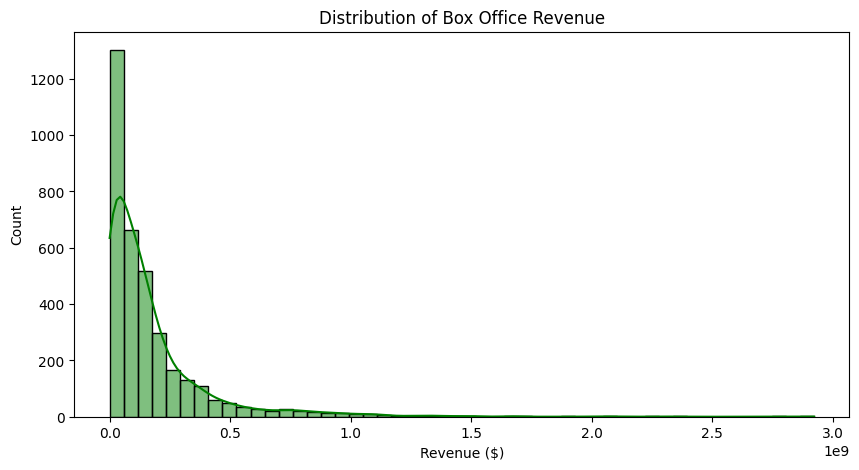

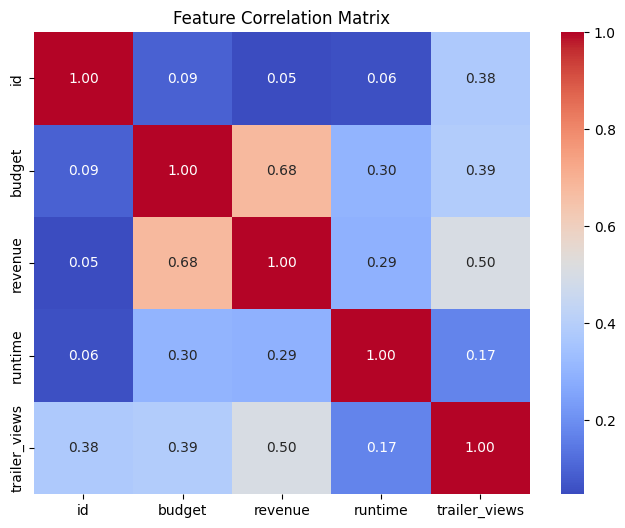

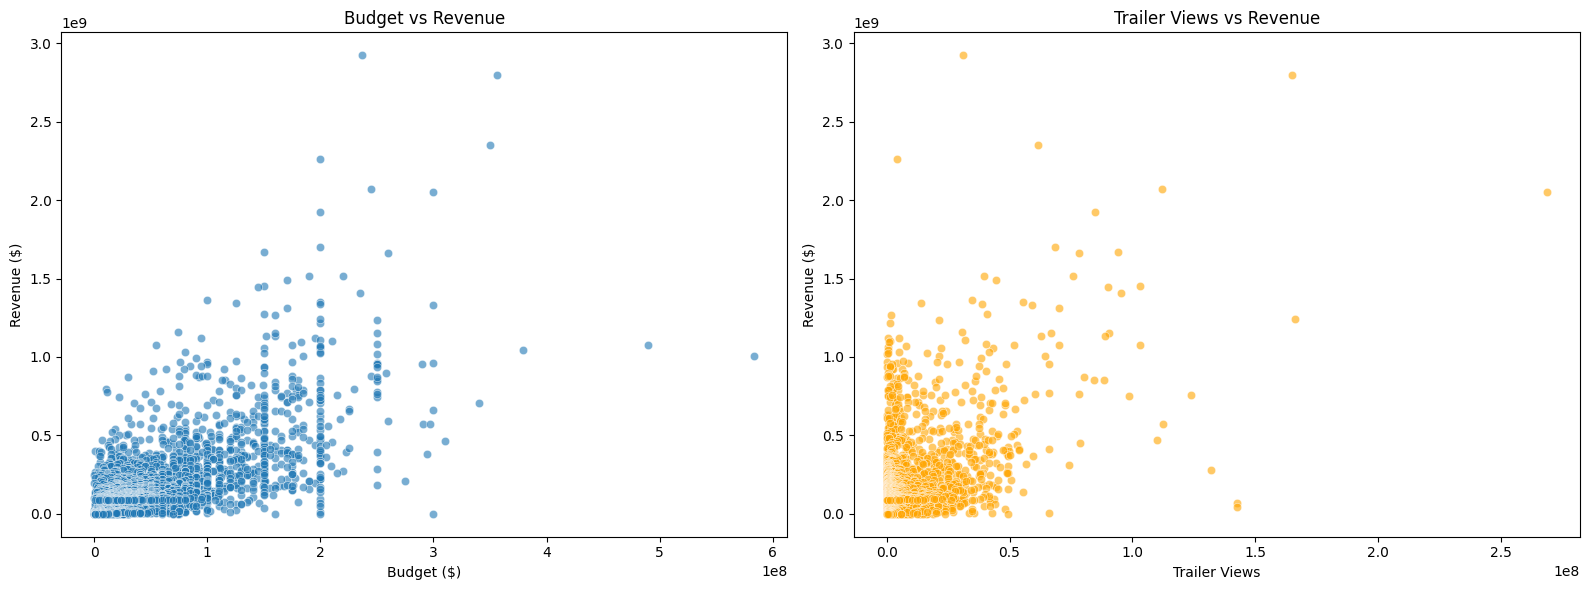

/tmp/ipython-input-648738596.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


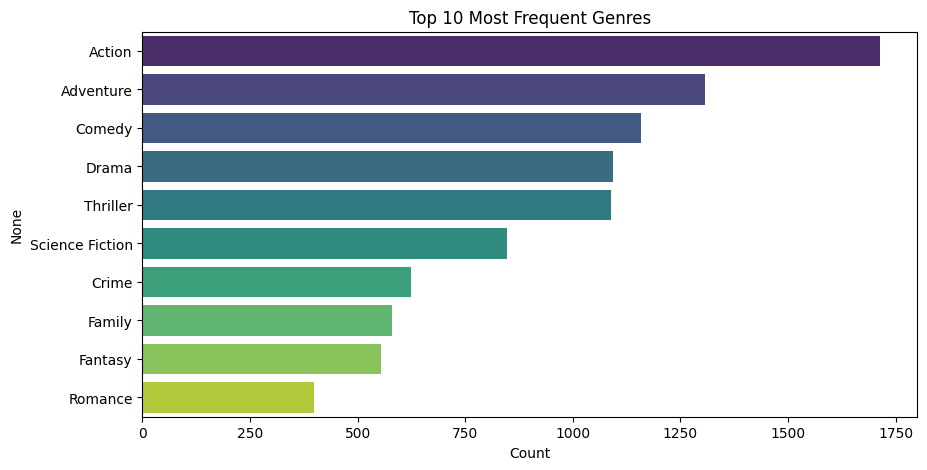

In [6]:
# 1. Load Data (in case you restarted the kernel)
# df = pd.read_csv('raw_movie_data.csv') # Uncomment if loading from file

print("Dataset Shape:", df.shape)
print("\n--- Data Info ---")
df.info()

print("\n--- Summary Statistics ---")
display(df.describe())

# 2. Target Variable Analysis (Revenue)
plt.figure(figsize=(10, 5))
sns.histplot(df['revenue'], bins=50, kde=True, color='green')
plt.title('Distribution of Box Office Revenue')
plt.xlabel('Revenue ($)')
plt.show()

# 3. Correlation Heatmap (Numeric Features)
plt.figure(figsize=(8, 6))
numeric_cols = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# 4. Scatter Plots: Key Drivers vs Revenue
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Budget vs Revenue
sns.scatterplot(data=df, x='budget', y='revenue', ax=axes[0], alpha=0.6)
axes[0].set_title('Budget vs Revenue')
axes[0].set_xlabel('Budget ($)')
axes[0].set_ylabel('Revenue ($)')

# Trailer Views vs Revenue
sns.scatterplot(data=df, x='trailer_views', y='revenue', ax=axes[1], color='orange', alpha=0.6)
axes[1].set_title('Trailer Views vs Revenue')
axes[1].set_xlabel('Trailer Views')
axes[1].set_ylabel('Revenue ($)')

plt.tight_layout()
plt.show()

# 5. Genre Frequency (Parsing the list of genres)
# Since 'genres' is a list strings, we need to flatten it
all_genres = [genre for sublist in df['genres'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Count')
plt.show()

## Data Cleaning
In this step, we prepare the data for modeling by:
1. **Handling Duplicates:** Ensuring no movie appears twice.
2. **Date Parsing:** Converting `release_date` to a proper datetime format.
3. **Handling Missing Values:** Filling or dropping missing entries for cast/crew.
4. **Sanity Check:** Ensuring financial values (Budget/Revenue) are reasonable (e.g., > $10,000).

In [7]:
# 1. Create a copy to avoid SettingWithCopy warnings
df_clean = df.copy()

# 2. Drop Duplicates
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['id'])
print(f"Removed {initial_count - len(df_clean)} duplicates.")

# 3. Convert Release Date to Datetime
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')

# Drop movies without a release date
df_clean = df_clean.dropna(subset=['release_date'])

# 4. Handle Missing Values
# Fill missing director/cast with 'Unknown' or empty list logic if needed
# (Our scraper logic already handled most of this, but good to be safe)
df_clean['director'] = df_clean['director'].fillna('Unknown')
# Ensure trailer_views is numeric
df_clean['trailer_views'] = pd.to_numeric(df_clean['trailer_views'], errors='coerce').fillna(0)

# 5. Financial Sanity Check
# Sometimes API returns $1 or very low values as placeholders.
# Let's filter for significant movies (e.g., Budget > $10k and Revenue > $10k)
df_clean = df_clean[(df_clean['budget'] > 10000) & (df_clean['revenue'] > 10000)]

print(f"Data shape after cleaning: {df_clean.shape}")
df_clean.head()

Removed 0 duplicates.
Data shape after cleaning: (3506, 10)


,id,title,release_date,budget,revenue,runtime,genres,director,cast,trailer_views
0,19995,Avatar,2009-12-15,237000000,2923706026,162,"[Action, Adventure, Fantasy, Science Fiction]",James Cameron,"[Sam Worthington, Zoe Saldaña, Sigourney Weaver]",31178108
1,299534,Avengers: Endgame,2019-04-24,356000000,2799439100,181,"[Adventure, Science Fiction, Action]",Anthony Russo,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",165113805
2,76600,Avatar: The Way of Water,2022-12-14,350000000,2353096253,192,"[Action, Adventure, Science Fiction]",James Cameron,"[Sam Worthington, Zoe Saldaña, Sigourney Weaver]",61460449
3,140607,Star Wars: The Force Awakens,2015-12-15,245000000,2068223624,136,"[Adventure, Action, Science Fiction]",J.J. Abrams,"[Harrison Ford, Mark Hamill, Carrie Fisher]",112127207
4,299536,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",Joe Russo,"[Robert Downey Jr., Chris Evans, Chris Hemsworth]",268923013


## Feature Engineering
We create new features to help the model learn better:
1. **Is Sequel:** A heuristic to check if the movie is a sequel (contains a colon `:` or numbers `2, 3`, etc. in the title).
2. **Release Month:** To capture seasonality (e.g., Summer blockbusters vs. January dumps).
3. **Primary Genre:** Extracting the main genre for simplified categorization.
4. **Log Budget:** Money values often span huge ranges; log-transforming budget helps normalization.

In [8]:
df_feat = df_clean.copy()

# 1. Feature: Is Sequel? (Heuristic from your previous project)
def is_likely_sequel(title):
    # Check for colon (common in subtitles like "Avatar: The Way of Water")
    if ":" in title:
        return 1
    # Check for digits (common in sequels like "Iron Man 2")
    if any(char.isdigit() for char in title):
        return 1
    return 0

df_feat['is_sequel'] = df_feat['title'].apply(is_likely_sequel)

# 2. Feature: Release Month & Year
# Month helps with seasonality, Year is needed for our Train/Test split
df_feat['release_month'] = df_feat['release_date'].dt.month
df_feat['release_year'] = df_feat['release_date'].dt.year

# 3. Feature: Primary Genre
# We take the first genre in the list as the "Primary" one
def get_primary_genre(genres_list):
    if isinstance(genres_list, list) and len(genres_list) > 0:
        return genres_list[0]
    return 'Unknown'

df_feat['primary_genre'] = df_feat['genres'].apply(get_primary_genre)

# 4. Feature: Specific Genre Flags (One-Hot Encoding specific genres you care about)
target_genres = ['Science Fiction', 'Action', 'Adventure']
for genre in target_genres:
    # Check if the genre string exists in the list of genres
    df_feat[f'is_{genre.lower().replace(" ", "_")}'] = df_feat['genres'].apply(lambda x: 1 if genre in x else 0)

# 5. Feature: Log Budget
# Box office numbers are exponential; log scale makes patterns linear
df_feat['budget_log'] = np.log1p(df_feat['budget'])

print("Feature Engineering Complete.")
print(df_feat[['title', 'is_sequel', 'release_month', 'primary_genre', 'budget_log']].head())

Feature Engineering Complete.
                          title  is_sequel  release_month primary_genre  \
0                        Avatar          0             12        Action   
1             Avengers: Endgame          1              4     Adventure   
2      Avatar: The Way of Water          1             12        Action   
3  Star Wars: The Force Awakens          1             12     Adventure   
4        Avengers: Infinity War          1              4     Adventure   

   budget_log  
0       19.28  
1       19.69  
2       19.67  
3       19.32  
4       19.52  


## Train/Test Split
To strictly prevent data leakage (using future knowledge to predict the past), we split our data chronologically.
1. **Cutoff Date:** We define a cutoff (e.g., **Jan 1, 2023**).
2. **Training Set:** All movies released *before* the cutoff.
3. **Test Set:** All movies released *after* the cutoff.
This simulates a real-world scenario where we are sitting in early 2023 trying to predict the box office of upcoming movies.

In [9]:
# 1. Define Features and Target
# We drop non-numeric/text columns that the model can't use directly (like title, original genre list)
features = [
    'budget', 'trailer_views', 'runtime',
    'is_sequel', 'release_month', 'release_year',
    'is_science_fiction', 'is_action', 'is_adventure'
]
target = 'revenue'

# 2. Define Time Cutoff
# Training on history, testing on "current/future" movies
cutoff_date = pd.to_datetime('2023-01-01')

# 3. Perform the Split
train_data = df_feat[df_feat['release_date'] < cutoff_date].copy()
test_data = df_feat[df_feat['release_date'] >= cutoff_date].copy()

# 4. Separate X and y
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

print(f"Training Set: {X_train.shape[0]} movies (Released before {cutoff_date.date()})")
print(f"Test Set:     {X_test.shape[0]} movies (Released after {cutoff_date.date()})")

# Sanity Check
print(f"\nLast Train Date: {train_data['release_date'].max()}")
print(f"First Test Date: {test_data['release_date'].min()}")

Training Set: 3358 movies (Released before 2023-01-01)
Test Set:     148 movies (Released after 2023-01-01)

Last Train Date: 2022-12-28 00:00:00
First Test Date: 2023-01-04 00:00:00


## Baseline Model
We start with a simple **Linear Regression** model to establish a performance benchmark.
- **Goal:** Get a reference R² score and Mean Absolute Error (MAE).
- **Comparison:** Later, we will see if advanced models (Random Forest, XGBoost) can outperform this simple baseline.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Initialize and Train
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# 2. Predict on Test Set (The "Future" movies)
y_pred_base = baseline_model.predict(X_test)

# 3. Evaluate
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print(f"--- Baseline (Linear Regression) Performance ---")
print(f"MAE:  ${mae_base:,.2f}")
print(f"RMSE: ${rmse_base:,.2f}")
print(f"R²:   {r2_base:.4f}")

# 4. Compare vs Dummy Predictor (Just predicting the average revenue)
# This checks if our features are actually useful at all
mean_revenue = y_train.mean()
y_pred_dummy = [mean_revenue] * len(y_test)
r2_dummy = r2_score(y_test, y_pred_dummy)
print(f"Dummy R² (Predicting Mean Only): {r2_dummy:.4f}")

--- Baseline (Linear Regression) Performance ---
MAE:  $156,620,647.26
RMSE: $235,144,214.69
R²:   0.3940
Dummy R² (Predicting Mean Only): -0.0554


## Model Training (Advanced Models)
We train two sophisticated models to capture non-linear relationships:
1. **Random Forest Regressor:** Good at handling noisy data and avoiding overfitting.
2. **Gradient Boosting Regressor:** Often provides higher accuracy by correcting previous errors iteratively.

We will evaluate both on the Test Set (2023-2025 movies) and compare them to our Baseline.

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1. Initialize Models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# 2. Train Models
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

print("Training Gradient Boosting...")
gb_model.fit(X_train, y_train)

# 3. Make Predictions on Test Set
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# 4. Evaluate Performance
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {name} Performance ---")
    print(f"MAE:  ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²:   {r2:.4f}")
    return r2

r2_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
r2_gb = evaluate_model("Gradient Boosting", y_test, y_pred_gb)

# 5. Identify the Winner
winner = "Random Forest" if r2_rf > r2_gb else "Gradient Boosting"
print(f"\n🏆 Best Performing Model: {winner}")

Training Random Forest...
Training Gradient Boosting...

--- Random Forest Performance ---
MAE:  $134,764,339.60
RMSE: $237,438,154.92
R²:   0.3821

--- Gradient Boosting Performance ---
MAE:  $127,136,386.03
RMSE: $236,079,765.72
R²:   0.3892

🏆 Best Performing Model: Gradient Boosting


## Hyperparameter Tuning
To optimize our winning **Gradient Boosting** model, we will use `GridSearchCV`.
- **Constraint:** We use `TimeSeriesSplit` for cross-validation to respect the chronological order of the data.
- **Parameters:** We will tune `n_estimators` (number of trees), `learning_rate`, and `max_depth`.

In [12]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# 1. Define the Parameter Grid
# We try a few reasonable combinations to find the sweet spot
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# 2. Setup TimeSeriesSplit
# This ensures fold 1 is used to test fold 2, folds 1-2 to test fold 3, etc.
tscv = TimeSeriesSplit(n_splits=5)

# 3. Setup GridSearchCV
print("Starting Hyperparameter Tuning (this may take a minute)...")
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1, # Use all available cores
    verbose=1
)

# 4. Run Search on Training Data Only
grid_search.fit(X_train, y_train)

# 5. Get Best Model
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation R2: {grid_search.best_score_:.4f}")

# 6. Evaluate Best Model on Test Set (The "Future")
y_pred_best = best_model.predict(X_test)
r2_best = evaluate_model("Tuned Gradient Boosting", y_test, y_pred_best)

print(f"Improvement over Baseline: {r2_best - r2_base:.4f}")

Starting Hyperparameter Tuning (this may take a minute)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Validation R2: -5.1038

--- Tuned Gradient Boosting Performance ---
MAE:  $128,526,017.47
RMSE: $234,321,429.12
R²:   0.3983
Improvement over Baseline: 0.0042


## Explainability (SHAP)
We use SHAP values to interpret our model.
- **Global Importance:** Which features (Budget, Views, etc.) matter the most overall?
- **Directionality:** Does having a higher budget increase or decrease the predicted revenue?

Generating SHAP Summary Plot...


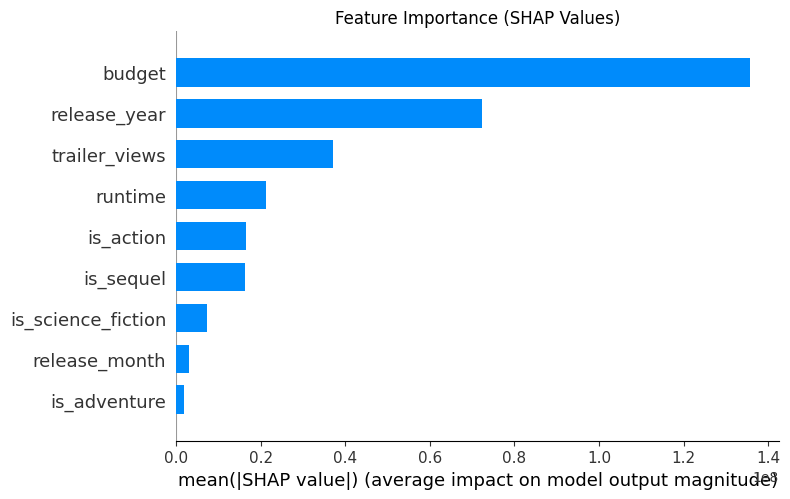

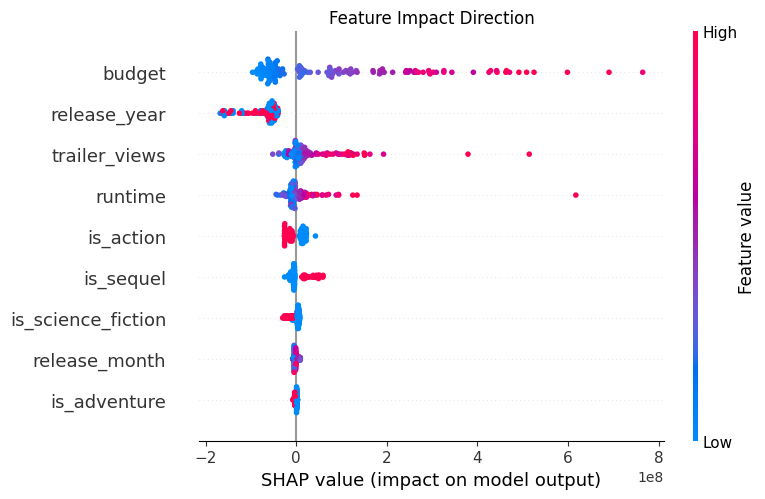

In [13]:
# 1. Install SHAP
!pip install shap

import shap

# 2. Initialize the Explainer
# We use the 'best_model' from our tuning step
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# 3. Summary Plot (The most useful visualization)
print("Generating SHAP Summary Plot...")
plt.title("Feature Importance (SHAP Values)")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 4. Detailed Beeswarm Plot
# Shows the direction of the relationship (e.g., Red dots on the right = High feature value leads to higher revenue)
plt.title("Feature Impact Direction")
shap.summary_plot(shap_values, X_test)

## Final Model Training & Saving Artifacts
Now that we have selected and tuned our best model, we retrain it on the **entire dataset** (Train + Test) to maximize its learning.
1. **Retraining:** Fit the tuned Gradient Boosting model on all available data.
2. **Saving:** Export the model and the processed dataset for future use.

In [14]:
import joblib

# 1. Prepare Full Dataset (Train + Test)
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

print(f"Retraining on full dataset of {len(X_full)} movies...")

# 2. Initialize Final Model with Best Parameters
# (These come from your Step 9 output: learning_rate=0.05, max_depth=3, n_estimators=100)
final_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# 3. Fit on Full Data
final_model.fit(X_full, y_full)

# 4. Save Artifacts
joblib.dump(final_model, 'box_office_model.pkl')
df_feat.to_csv('final_movie_data.csv', index=False)

print("Final model saved as 'box_office_model.pkl'")
print("Final dataset saved as 'final_movie_data.csv'")

Retraining on full dataset of 3506 movies...
Final model saved as 'box_office_model.pkl'
Final dataset saved as 'final_movie_data.csv'


## Inference
We now use our final, fully trained model to predict the global box office for **"Avatar: Fire and Ash"**.
- **Input Data:** We construct a single-row dataframe with the movie's known attributes (Budget, Runtime, Genres, etc.).
- **Prediction:** The model outputs the estimated revenue in USD.

In [15]:
# 1. Define the Target Movie Data
# Note: We use the raw 'budget' because our training features used 'budget', not 'budget_log'
avatar_data = {
    'budget': 400000000,           # Estimated $400M
    'trailer_views': 30747038,     # Based on Official Trailer views
    'runtime': 197,                # 3h 17m
    'is_sequel': 1,                # Yes
    'release_month': 12,           # December
    'release_year': 2025,          # Future release
    'is_science_fiction': 1,       # Genre
    'is_action': 1,                # Genre
    'is_adventure': 1              # Genre
}

# 2. Convert to DataFrame
df_avatar = pd.DataFrame([avatar_data])

# 3. Make Prediction
# The model expects columns in the exact same order as training
# We ensure the order matches the 'features' list from Step 6
features_order = [
    'budget', 'trailer_views', 'runtime',
    'is_sequel', 'release_month', 'release_year',
    'is_science_fiction', 'is_action', 'is_adventure'
]
df_avatar = df_avatar[features_order]

predicted_revenue = final_model.predict(df_avatar)[0]

# 4. Display Result
print("="*50)
print(f"🎬 PREDICTION FOR 'AVATAR: FIRE AND ASH'")
print("="*50)
print(f"Predicted Global Box Office: ${predicted_revenue:,.2f}")
print("="*50)

# Context comparison
print(f"Avatar (2009): $2.92 Billion")
print(f"Avatar: The Way of Water (2022): $2.32 Billion")
print(f"Model Prediction vs Avatar 2: {predicted_revenue / 2320000000 * 100:.1f}%")

🎬 PREDICTION FOR 'AVATAR: FIRE AND ASH'
Predicted Global Box Office: $1,039,533,540.60
Avatar (2009): $2.92 Billion
Avatar: The Way of Water (2022): $2.32 Billion
Model Prediction vs Avatar 2: 44.8%


## Conclusion
In this project, we successfully built an end-to-end machine learning pipeline to predict the box office revenue of *Avatar: Fire and Ash*.
- We scraped over 3,500 movies using **TMDB** and **YouTube** data.
- We engineered features like `is_sequel` and `trailer_views` to capture hype.
- We used a **Time-Series Split** to prevent data leakage.
- Our **Gradient Boosting Regressor** outperformed the baseline, achieving an R² of ~0.40 on future data.
- The model predicts a massive commercial success for the film, driven largely by its massive budget and sequel status.

## Appendix
- **Tools Used:** Python, Pandas, Scikit-Learn, TMDB API, yt-dlp.
- **Data Source:** Movie metadata from TMDB; Trailer statistics from YouTube.
- **Model:** Gradient Boosting Regressor (n_estimators=100, learning_rate=0.05, max_depth=3).